In [1]:
import requests
from bs4 import BeautifulSoup
import re
import bs4
import time
import datetime

import numpy as np

import multiprocessing

import pandas as pd

In [65]:
ls

__init__.py        allname.txt        main.py            stock.ipynb
__pycache__/       dayprice.py        name.txt           weekprice.py
agent.py           hot.txt            paEA.py
algo.py            hotstock.py        pctest.ipynb
all.py             ld.csv             staocknamelist.py


In [75]:
class Job:
    def __init__(self,
                 n_jobs=-1,
                save_path="last.txt"):
        self.n_jobs = n_jobs
        self.save_path = save_path

    def judge(self, data):
        ex_ratio = []
        prices = []
        for line in data:
            try:
                ex_ratio.append(float(line[10]))
                prices.append(float(line[4]))
            except:
                pass
                # print(line)
        try:
            last_two = prices[:2]
            mid = prices[2:10]
            second_n = prices[2:60]
            if np.mean(last_two) > np.mean(second_n) and np.mean(mid) < 1.1 * np.mean(second_n):
                print("check1")
                print(last_two)
                print("check2")
                print(second_n)
                print("nice stock", data[2][2])
                return True
                
#             mid = np.median(temp)
#             temp_sort = sorted(temp)
#             mid_90 = temp_sort[int(0.85 * len(temp))]
#             now = np.mean(temp[:2])
#             if now > mid and now < mid_90:
#                 print("nice stock", data[2][2])
#                 print(mid, mid_90, now)
#                 return True
        except:
            return False
        return False

    def get_fit_stock(self, keys):
        lists = []
        for key in keys:
            data = getHistoryTradeInfo(key, ndays=150)
            if data is None:
                continue
            else:
                if self.judge(data):
                    if "*" not in data[2][2] and "S" not in data[2][2] and "s" not in data[2][2]:
                        print(key, data[2][2])
                        lists.append([key, data[2][2]])
                        if(len(lists) >5):
                            self.save_data(lists)
                            return lists
                else:
                    pass
        self.save_data(lists)
        return lists
    
    def save_data(self, data):
        with open(self.save_path, "a") as f:
            for line in data:
                f.write(line[0] + "\t" + line[1] + "\n")

    def split_data(self, n_jobs):
        stock_code_list = get_name("allname.txt") #[:28]
        indexs = int((len(stock_code_list) - 1) / n_jobs) + 1
        for id in range(n_jobs):
            temp = stock_code_list[indexs * id: (id + 1) * indexs]
            yield temp

    def savedata_multiprocess(self):
        # logging.log(logging.INFO, "db infomation are {}".format(mins))
        if self.n_jobs == -1:
            # 获取 cpu的个数
            n_jobs = multiprocessing.cpu_count() - 1
        else:
            n_jobs = self.n_jobs
        print("n_jobs is {}".format(n_jobs))

        def get_mu(q, keys):
            mylist = self.get_fit_stock(keys)
            q.put(len(mylist))

        q = multiprocessing.Queue()
        myqueus = []
        sums = 0
        for ids, p_list in enumerate(self.split_data(n_jobs)):
            temp_job = multiprocessing.Process(target=get_mu, args=(q, p_list), name="jon_{}".format(ids))
            myqueus.append(temp_job)
        for job in myqueus:
            job.start()
        for job in myqueus:
            job.join()
        for _ in range(n_jobs):
            sums += q.get()
        print("total stocks is {}".format(sums))

if __name__ == "__main__":
    #names = get_name("allname.txt")
    #stock_code = get_fit_stock(names[:10])
    #print(stock_code)
    my = Job(n_jobs=-1)
    my.savedata_multiprocess()

n_jobs is 7
上市 date 19960418 - 数据开始时间 20200113
http://quotes.money.163.com/service/chddata.html?code=0600898&start=20200113&end=20200611&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;TURNOVER;VOTURNOVER;VATURNOVER;TCAP;MCAP
上市 date  - 数据开始时间 20200113
上市 date  - 数据开始时间 20200113
上市 date 20000615 - 数据开始时间 20200113
http://quotes.money.163.com/service/chddata.html?code=0600234&start=20200113&end=20200611&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;TURNOVER;VOTURNOVER;VATURNOVER;TCAP;MCAP
上市 date 20120327 - 数据开始时间 20200113
上市 date 19980609 - 数据开始时间 20200113
http://quotes.money.163.com/service/chddata.html?code=1002666&start=20200113&end=20200611&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;TURNOVER;VOTURNOVER;VATURNOVER;TCAP;MCAP
http://quotes.money.163.com/service/chddata.html?code=0600152&start=20200113&end=20200611&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;TURNOVER;VOTURNOVER;VATURNOVER;TCAP;MCAP
上市 date  - 数据开始时间 20200113
check1
[7.56, 7.82]
check2
[7.52, 7.16, 6.84, 6.81, 6.49, 6.18,

nice stock 怡球资源
601388 怡球资源
上市 date  - 数据开始时间 20200113
上市 date 19960823 - 数据开始时间 20200113
http://quotes.money.163.com/service/chddata.html?code=1000603&start=20200113&end=20200611&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;TURNOVER;VOTURNOVER;VATURNOVER;TCAP;MCAP
上市 date 20040225 - 数据开始时间 20200113
http://quotes.money.163.com/service/chddata.html?code=0600325&start=20200113&end=20200611&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;TURNOVER;VOTURNOVER;VATURNOVER;TCAP;MCAP
check1
[12.41, 12.19]
check2
[12.32, 12.27, 12.19, 12.13, 12.21, 13.19, 13.25, 12.46, 12.5, 12.41, 12.38, 11.58, 11.89, 12.68, 13.2, 13.08, 13.53, 12.59, 11.98, 11.92, 12.03, 12.35, 11.97, 11.06, 11.14, 10.99, 10.61, 11.1, 11.47, 11.78, 11.86, 11.48, 11.92, 11.84, 12.34, 12.54, 12.87, 12.97, 12.03, 12.47, 12.08, 11.86, 11.95, 11.66, 11.3, 11.33, 11.43, 11.45, 12.09, 12.07, 12.5, 12.61, 11.98, 11.68, 10.63, 10.92, 11.13, 11.54]
nice stock 盛达资源
000603 盛达资源
上市 date  - 数据开始时间 20200113
check1
[7.0, 6.92]
check2
[6.94, 6.95

上市 date 19960829 - 数据开始时间 20200113
http://quotes.money.163.com/service/chddata.html?code=1000430&start=20200113&end=20200611&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;TURNOVER;VOTURNOVER;VATURNOVER;TCAP;MCAP
check1
[30.48, 30.7]
check2
[30.75, 30.0, 27.36, 27.25, 27.58, 29.13, 29.17, 27.9, 27.74, 27.95, 27.45, 28.06, 28.67, 29.14, 29.23, 29.0, 27.93, 28.17, 28.19, 28.2, 27.68, 28.44, 28.56, 28.75, 28.93, 30.0, 28.9, 27.4, 26.99, 26.97, 26.47, 26.24, 26.56, 27.07, 27.35, 24.96, 25.25, 25.34, 25.81, 26.5, 26.15, 26.42, 26.09, 25.05, 24.01, 24.63, 24.51, 25.0, 25.58, 25.69, 26.14, 25.8, 24.99, 25.52, 25.86, 26.4, 26.66, 27.9]
nice stock ½õ½­¾Æµê
600754 ½õ½­¾Æµê
上市 date 19991209 - 数据开始时间 20200113
http://quotes.money.163.com/service/chddata.html?code=1000955&start=20200113&end=20200611&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;TURNOVER;VOTURNOVER;VATURNOVER;TCAP;MCAP
上市 date  - 数据开始时间 20200113
上市 date  - 数据开始时间 20200113
上市 date 20030311 - 数据开始时间 20200113
http://quotes.money.163.com/se

nice stock 龙洲股份
002682 龙洲股份


/Users/luokui/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/luokui/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


上市 date  - 数据开始时间 20200113
上市 date 20000731 - 数据开始时间 20200113
http://quotes.money.163.com/service/chddata.html?code=0600279&start=20200113&end=20200611&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;TURNOVER;VOTURNOVER;VATURNOVER;TCAP;MCAP
上市 date 19970625 - 数据开始时间 20200113
http://quotes.money.163.com/service/chddata.html?code=1000752&start=20200113&end=20200611&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;TURNOVER;VOTURNOVER;VATURNOVER;TCAP;MCAP
上市 date 20000731 - 数据开始时间 20200113
http://quotes.money.163.com/service/chddata.html?code=1000993&start=20200113&end=20200611&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;TURNOVER;VOTURNOVER;VATURNOVER;TCAP;MCAP
上市 date 19970108 - 数据开始时间 20200113
http://quotes.money.163.com/service/chddata.html?code=0600272&start=20200113&end=20200611&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;TURNOVER;VOTURNOVER;VATURNOVER;TCAP;MCAP
上市 date  - 数据开始时间 20200113
上市 date 19990923 - 数据开始时间 20200113
http://quotes.money.163.com/service/chddata.html?code=1000939&start

/Users/luokui/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/luokui/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


check1
[16.77, 16.75]
check2
[16.08, 16.18, 16.49, 16.78, 16.21, 16.41, 16.15, 15.77, 16.17, 15.54, 15.7, 15.05, 14.86, 14.76, 14.96, 15.06, 15.15, 15.38, 15.64, 15.58, 15.2, 15.58, 15.45, 15.2, 15.19, 15.6, 15.44, 15.07, 15.34, 16.4, 16.65, 15.93, 16.3, 16.99, 16.68, 15.67, 15.55, 14.93, 14.62, 15.43, 15.61, 15.03, 15.15, 15.03, 14.97, 14.11, 13.97, 13.9, 14.93, 15.13, 15.5, 14.28, 14.07, 14.38, 13.87, 14.13, 13.96, 14.82]
nice stock 齐心集团
002301 齐心集团
上市 date 20040909 - 数据开始时间 20200113
上市 date 20100921 - 数据开始时间 20200113
http://quotes.money.163.com/service/chddata.html?code=1002038&start=20200113&end=20200611&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;TURNOVER;VOTURNOVER;VATURNOVER;TCAP;MCAP
http://quotes.money.163.com/service/chddata.html?code=1002479&start=20200113&end=20200611&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;TURNOVER;VOTURNOVER;VATURNOVER;TCAP;MCAP
上市 date 20070112 - 数据开始时间 20200113
http://quotes.money.163.com/service/chddata.html?code=1002106&start=20200113&end=202006

上市 date 19940928 - 数据开始时间 20200113
http://quotes.money.163.com/service/chddata.html?code=1000043&start=20200113&end=20200611&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;TURNOVER;VOTURNOVER;VATURNOVER;TCAP;MCAP
上市 date 20100511 - 数据开始时间 20200113
http://quotes.money.163.com/service/chddata.html?code=1002404&start=20200113&end=20200611&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;TURNOVER;VOTURNOVER;VATURNOVER;TCAP;MCAP
check1
[6.43, 6.3]
check2
[6.21, 6.19, 6.27, 6.35, 6.43, 6.51, 6.11, 6.12, 6.35, 6.07, 6.07, 5.93, 6.02, 6.05, 6.19, 5.8, 5.92, 5.66, 6.15, 5.59, 5.57, 5.56, 5.57, 5.54, 5.47, 5.4, 5.28, 5.38, 5.39, 5.46, 5.51, 5.43, 5.44, 5.45, 5.5, 5.43, 5.52, 5.49, 5.44, 5.64, 5.78, 5.66, 5.52, 5.47, 5.46, 5.45, 5.49, 5.56, 5.77, 5.64, 5.71, 5.57, 5.63, 5.79, 5.74, 5.83, 5.87, 6.12]
nice stock ����˿��
002404 ����˿��
上市 date  - 数据开始时间 20200113
上市 date 19981203 - 数据开始时间 20200113
http://quotes.money.163.com/service/chddata.html?code=0600218&start=20200113&end=20200611&fields=TCLOSE;HIGH;L

In [25]:
获取所有股票的代码

# import requests
# from bs4 import BeautifulSoup
# import re
 
# def getHTMLpages(url):
#     try:
#         r = requests.get(url, timeout=30)
#         r.raise_for_status()
#         r.encoding = r.apparent_encoding
#         return r.text
#     except:
#         return ""
#  将股票信息存入列表
# def getSharelist(html):
#     soup = BeautifulSoup(html, "html.parser")
#     tags = soup.find_all('a', target="_blank") # a标签的target属性值为"_blank"
#     sets = set()
#     for tag in tags:
#         str1 = tag.attrs['href']  # 获得链接信息
#         match = re.search(r's[hz]\d{6}', str1)  # 从链接中找到股票代码
#         if match:  # 必须加判断，因为有的链接不符合，这样的话正则表达式匹配不到，match.group(0)就是空的，会报错TypeError
#             name = match.group(0)
#             if name[2] in set(['0', '6']):
#                 sets.add(name[2:])
#         else:
#             continue
#     return sets
 

# url1 = "http://quote.eastmoney.com/stock_list.html"
# html = getHTMLpages(url1)
# mystock = getSharelist(html)

In [14]:
#d  = requests.get("http://guba.eastmoney.com")
d = requests.get("http://guba.eastmoney.com/default,0_2.html")

soup = BeautifulSoup(d.text, 'lxml')
res = soup.find_all(class_="balink")

In [261]:
# 获取最近热度最大的几个股票

def get_gubai(res, save=('0', '6')):
    maps = {}
    hot = {}
    for line in res:
        temp_line = line['href']
        ids = temp_line.split(',')[1].split('.')[0]
        if ids[0] not in save:
            continue
        name = line.string
        maps.setdefault(ids, [name, temp_line])
        hot.setdefault(ids, 0)
        hot[ids] += 1
    return maps, hot

def get_latest(n=50):
    myhot = {}
    mymaps = {}
    for i in range(1, n+1):
        d = requests.get("http://guba.eastmoney.com/default,0_{}.html".format(i))
        soup = BeautifulSoup(d.text, 'lxml')
        res = soup.find_all(class_="balink")
        maps, hot = get_gubai(res)
        mymaps.update(maps)
        for key in hot.keys():
            if key in myhot.keys():
                myhot[key] += hot[key]
            else:
                myhot.setdefault(key, hot[key])
    return myhot, mymaps
myhot_1, mymaps_1 = get_latest()

In [399]:
# maps = get_gubai(res)

In [18]:
#p = list(maps.keys())[0]

In [16]:
def get_name(path):
    datas = set()
    with open(path, "r") as f:
        for line in f.readlines():
            datas.add(line.strip())
    return list(datas)
#names = get_name("allname.txt")
#names

In [4]:
def get_hotkey(path='hot.txt', nk=100):
    stock_list = {}
    with open(path) as f:
        for line in f.readlines():
            line = line.strip().split(" ")
            stock_list.setdefault(line[0], int(line[1]))
    stock_list = sorted(stock_list.items(), key=lambda s: s[1], reverse=-1)[:nk]
    return stock_list

In [71]:
def getHTMLText(url):
    try:
        r = requests.get(url)
        r.raise_for_status()
        r.encoding = r.apparent_encoding
        return r.text
    except:
        return ""


def getStockStartDate(stockCode, ndays=365 * 2):
    # 股票上市时间的 选择。 符合时间的股票
    html = getHTMLText("http://quotes.money.163.com/f10/gszl_" + stockCode + ".html#01f02")
    soup = BeautifulSoup(html, 'html.parser')
    try:
        a = soup.find_all('table', class_="table_bg001 border_box limit_sale table_details")[1]
    except:
        pass
        #date = time.strftime("%Y%m%d")
    cnt = 0
    date = ''
    for tr in a.children:
        if isinstance(tr, bs4.element.Tag):
            tds = tr('td')
            cnt = cnt + 1
            if(cnt == 2):
                date = tds[1].string.replace("-","")
                start = str((datetime.datetime.now() - datetime.timedelta(days=ndays)).date()).replace("-", "")
                print("上市 date {} - 数据开始时间 {}".format(date, start))
                if date > start or len(date) != 8:
                    return None
                else:
                    return start
    return None

def getHistoryTradeInfo(stockCode, ndays):
    # 获取股票的数据
    if stockCode.startswith('0'):
        t_stockCode = '1' + stockCode
    elif stockCode.startswith('6'):
        t_stockCode = '0' + stockCode
    else:
        raise KeyError("WRONG ")
        
    starts = getStockStartDate(stockCode, ndays)
    if starts is None:
        return None
    #print("start is {}".format(starts))
    download_url = "http://quotes.money.163.com/service/chddata.html?code=" + t_stockCode + "&start=" + starts + "&end=" + time.strftime("%Y%m%d") + "&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;TURNOVER;VOTURNOVER;VATURNOVER;TCAP;MCAP"
    print(download_url)
    data = requests.get(download_url)
    data = str(BeautifulSoup(data.text, 'lxml')).split('\r\n')[1:]
    data = [i.split(',') for i in data]
    return data

In [53]:
# 利用策略选股的方法

def judge(data):
    temp = []
    for line in data:
        try:
            temp.append(float(line[10]))
        except:
            pass
            # print(line)
    try:
        mid = np.median(temp)
        temp_sort = sorted(temp)
        mid_90 = temp_sort[int(0.85 * len(temp))]
    
        now = np.mean(temp[:2])
        if now > mid and now < mid_90:
            print("nice stock", data[2][2])
            print(mid, mid_90, now)
            return True
    except:
        return False
    return  False


def get_fit_stock(keys):
    lists = []
    for key in keys:
        data = getHistoryTradeInfo(key, ndays=300)
        if data is None:
            continue
        else:
            if judge(data):
                lists.append(key)
    return lists
get_fit_stock(names[:10])

上市 date  - 数据开始时间 20190816
上市 date 20080516 - 数据开始时间 20190816
http://quotes.money.163.com/service/chddata.html?code=1002235&start=20190816&end=20200611&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;TURNOVER;VOTURNOVER;VATURNOVER;TCAP;MCAP
上市 date 20100203 - 数据开始时间 20190816
http://quotes.money.163.com/service/chddata.html?code=1002349&start=20190816&end=20200611&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;TURNOVER;VOTURNOVER;VATURNOVER;TCAP;MCAP
nice stock 精华制药
0.5679000000000001 2.7522 0.99825
上市 date 19961126 - 数据开始时间 20190816
http://quotes.money.163.com/service/chddata.html?code=1000638&start=20190816&end=20200611&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;TURNOVER;VOTURNOVER;VATURNOVER;TCAP;MCAP
上市 date 19970509 - 数据开始时间 20190816
http://quotes.money.163.com/service/chddata.html?code=1000739&start=20190816&end=20200611&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;TURNOVER;VOTURNOVER;VATURNOVER;TCAP;MCAP
nice stock ぱ醫狻珛
1.27885 2.0387 1.9428
上市 date 20030114 - 数据开始时间 20190816
http:/

['002349', '000739', '002293']

In [32]:
# keys = get_hotkey()

In [49]:
d2 = getHistoryTradeInfo(names[3], ndays=100)
d2[0]

上市 date 19961126 - 数据开始时间 20200303
http://quotes.money.163.com/service/chddata.html?code=1000638&start=20200303&end=20200611&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;TURNOVER;VOTURNOVER;VATURNOVER;TCAP;MCAP


['2020-06-11',
 "'000638",
 '万方发展',
 '4.08',
 '4.17',
 '4.07',
 '4.14',
 '4.14',
 '-0.06',
 '-1.4493',
 '0.6915',
 '2139420',
 '8832139.2',
 '1262352000.0',
 '1262352000.0']

In [50]:
def extract(dx):
    price = []
    for line in dx[1:]:
        try:
            price.append([line[0], float(line[3])])
        except:
            print(line)
    return price
# newd2 = extract(d2)
#f = pd.DataFrame(newd2, columns=["time", "code"])
import time

def got_lastdata(keys, nday=100):
    l_d = None
    for idx in range(len(keys)):
        print(idx)
        temp_data = getHistoryTradeInfo(keys[idx], ndays=nday)
        if temp_data:
            try:
                ndata = extract(temp_data)
                ndata = pd.DataFrame(ndata, columns=["times", keys[idx]])
                if l_d is None:
                    l_d = ndata
                else:
                    l_d = pd.merge(l_d, ndata, on="times", how="left")
            except:
                pass
    return l_d
    

In [51]:
ld = got_lastdata(names[:10])

0
上市 date  - 数据开始时间 20200303
1
上市 date 20080516 - 数据开始时间 20200303
http://quotes.money.163.com/service/chddata.html?code=1002235&start=20200303&end=20200611&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;TURNOVER;VOTURNOVER;VATURNOVER;TCAP;MCAP
['</p></body></html>']
2
上市 date 20100203 - 数据开始时间 20200303
http://quotes.money.163.com/service/chddata.html?code=1002349&start=20200303&end=20200611&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;TURNOVER;VOTURNOVER;VATURNOVER;TCAP;MCAP
['</p></body></html>']
3
上市 date 19961126 - 数据开始时间 20200303
http://quotes.money.163.com/service/chddata.html?code=1000638&start=20200303&end=20200611&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;TURNOVER;VOTURNOVER;VATURNOVER;TCAP;MCAP
['</p></body></html>']
4
上市 date 19970509 - 数据开始时间 20200303
http://quotes.money.163.com/service/chddata.html?code=1000739&start=20200303&end=20200611&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;TURNOVER;VOTURNOVER;VATURNOVER;TCAP;MCAP
['</p></body></html>']
5
上市 date 20030114 - 数据开始时间

In [100]:
#mylists = get_fit_stock(keys)
len(keys)

100

In [35]:
# ld.to_csv("ld.csv")

for key in ld.columns:
    ld.loc[ld[key] == 0, key] = np.nan
    #data.loc[data['收盘价'] == 0, '收盘价'] = np.nan
    ld = ld.interpolate(method='nearest', limit_direction='both', axis=0)

In [36]:
ld['times'] = pd.to_datetime(ld['times'])

In [37]:
new_col = ld['times']
new_ld = ld.T.iloc[1:, :]
new_ld.columns = new_col

In [38]:
from sklearn.cluster import KMeans

In [39]:
km = KMeans(n_clusters=6, n_jobs=-1)

In [40]:
new_ld.head(10)

times,2020-06-10 00:00:00,2020-06-09 00:00:00,2020-06-08 00:00:00,2020-06-05 00:00:00,2020-06-04 00:00:00,2020-06-03 00:00:00,2020-06-02 00:00:00,2020-06-01 00:00:00,2020-05-29 00:00:00,2020-05-28 00:00:00,...,2020-03-16 00:00:00,2020-03-13 00:00:00,2020-03-12 00:00:00,2020-03-11 00:00:00,2020-03-10 00:00:00,2020-03-09 00:00:00,2020-03-06 00:00:00,2020-03-05 00:00:00,2020-03-04 00:00:00,2020-03-03 00:00:00
002235,7.95,8.02,7.99,7.99,7.64,7.64,7.59,7.56,7.3,7.24,...,8.49,8.88,9.16,9.54,9.88,9.61,10.26,10.62,10.47,10.23
002349,5.1,5.03,5.07,5.12,5.07,5.06,5,4.94,4.85,4.87,...,5.53,5.51,5.66,5.69,5.83,6.09,5.67,5.69,5.66,5.82
000638,4.14,4.18,4.16,4.15,4.19,4.19,4.16,4.15,4.06,4.02,...,4.79,5.15,5,4.91,5,4.78,4.91,5.03,4.94,4.77
000739,21.5,20.5,19.75,19.89,18.8,18.4,18.6,18.95,18.08,17.65,...,16.99,16.62,16.86,17.53,17.82,17.84,17.69,18,17.46,17.03
600538,7.7,7.73,7.7,7.68,7.69,7.86,7.69,7.74,7.73,7.67,...,6.72,6.54,6.13,6.05,5.79,5.78,5.74,5.48,5.51,5.23
002293,9.95,9.83,9.66,9.86,9.91,9.77,9.8,9.62,9.4,9.94,...,8.21,8.51,8.69,8.9,9.05,9.1,9.43,9.26,9.22,8.98
002630,2.06,2.09,2.07,2.09,2.1,2.1,2.11,2.11,2.06,2.09,...,2.31,2.38,2.41,2.47,2.49,2.43,2.49,2.43,2.44,2.32
600460,14.38,14.69,14.67,14.79,14.58,14.83,15.01,14.73,14.2,14.41,...,15.72,16.84,16.67,16.43,17.03,15.99,17.18,17.6,17.55,17.6


In [41]:
import matplotlib.pyplot as plt

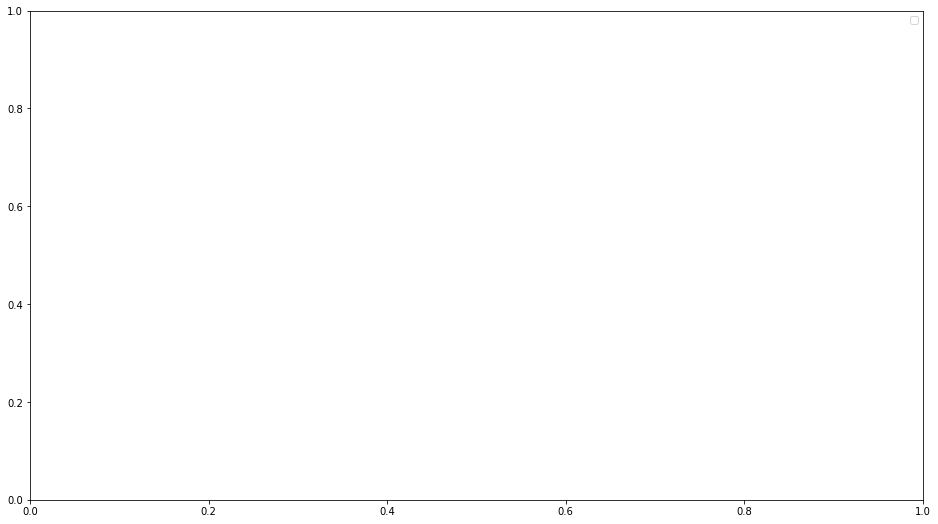

In [42]:
myplot(ld, 55, 66)

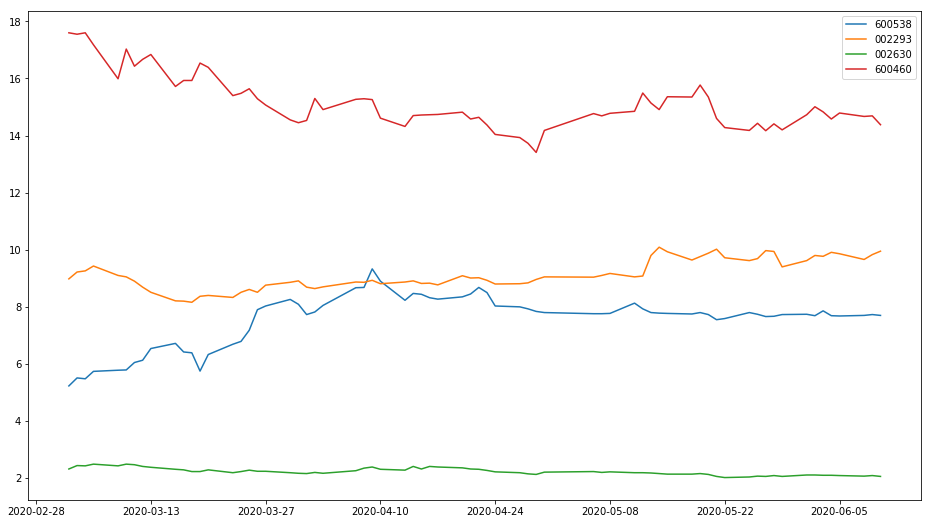

In [43]:
def myplot(data, start=5, end=28):
    plt.figure(figsize=(16, 9))
    for code in data.columns[start : end]:
        plt.plot(data['times'], data[code])
    plt.legend(data.columns[start: end])
myplot(ld)

In [117]:
ld.head(2)

,times,002506,000533,002581,600519,002220,002603,002397,002400,600095,...,600082,600123,000676,601018,000731,000987,600811,600721,600289,601177
0,2020-05-25,2.62,2.70,25.65,1362.9,0.67,28.85,8.01,6.68,9.98,...,3.35,4.72,8.63,3.34,5.04,12.02,3.69,4.36,5.30,7.71
1,2020-05-22,2.67,2.73,26.98,1328.2,0.70,28.44,8.90,6.80,10.42,...,3.29,4.69,8.61,3.33,5.23,12.25,3.69,4.59,5.05,7.74


In [101]:
ld.head(10)

,times,002506,000533,002581,600519,002220,002603,002397,002400,600095,...,600082,600123,000676,601018,000731,000987,600811,600721,600289,601177
0,2020-05-25,2.62,2.70,25.65,1362.90,0.67,28.85,8.01,6.68,9.98,...,3.35,4.72,8.63,3.34,5.04,12.02,3.69,4.36,5.30,7.71
1,2020-05-22,2.67,2.73,26.98,1328.20,0.70,28.44,8.90,6.80,10.42,...,3.29,4.69,8.61,3.33,5.23,12.25,3.69,4.59,5.05,7.74
2,2020-05-21,2.75,2.80,27.64,1366.10,0.74,30.48,9.66,7.43,0.00,...,3.35,4.78,8.43,3.35,5.25,11.65,3.75,4.66,4.81,7.78
3,2020-05-20,2.70,2.80,29.70,1351.00,0.78,29.60,9.35,6.75,11.29,...,3.29,4.79,9.22,3.38,5.25,11.83,3.82,4.74,5.06,7.85
4,2020-05-19,2.64,2.87,27.00,1346.11,0.82,30.50,8.50,7.43,10.59,...,3.28,4.84,8.38,3.41,5.38,12.59,3.92,4.86,4.82,7.88
5,2020-05-18,2.61,2.87,26.91,1346.21,0.86,30.71,7.73,7.40,10.20,...,3.27,4.83,8.55,3.42,5.16,12.09,3.96,4.84,4.66,7.83
6,2020-05-15,2.52,2.97,29.90,1313.00,0.91,32.28,7.03,7.23,10.14,...,3.32,4.78,8.95,3.50,5.07,11.66,3.88,4.81,4.46,7.91
7,2020-05-14,2.51,2.90,27.18,1326.59,0.87,32.00,6.39,6.57,9.22,...,3.32,4.80,8.14,3.36,5.17,10.60,3.84,4.92,4.25,7.96
8,2020-05-13,2.57,2.97,26.11,1335.95,0.85,33.09,5.81,6.69,9.47,...,3.32,4.82,7.40,3.39,5.39,10.94,3.93,5.18,4.05,8.16
9,2020-05-12,2.52,2.90,23.74,1333.00,0.86,33.97,5.28,6.08,9.32,...,3.34,4.81,7.37,3.39,5.14,10.73,3.78,5.20,4.26,8.23


In [20]:
data = getHistoryTradeInfo(keys[0][0], ndays=300)

start is 20190728
http://quotes.money.163.com/service/chddata.html?code=1002980&start=20190728&end=20200523&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;TURNOVER;VOTURNOVER;VATURNOVER;TCAP;MCAP


In [80]:
# 价格异常波动。
# 成交量变大。
# 上升区间。
# 盈利尚可，没意外的幺蛾子。
@日期	股票代码	名称	收盘价	最高价	最低价	开盘价	前收盘	涨跌额	涨跌幅	换手率	成交量	成交金额	总市值	流通市值
HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;TURNOVER;VOTURNOVER;VATURNOVER;TCAP;MCAP

In [398]:
data[0][0]

['2020-05-22',
 "'000987",
 '越秀金控',
 '12.25',
 '12.65',
 '11.47',
 '11.62',
 '11.65',
 '0.6',
 '5.1502',
 '2.0025',
 '53419634',
 '638680771.84',
 '33722838236.5',
 '32677927091.2']

In [ ]:
# http://guba.eastmoney.com/list,600485.html

# 爬取标题

In [7]:
path = 'http://guba.eastmoney.com'
all_path = path + '/list,600179_1.html'

In [8]:
all_path = 'http://guba.eastmoney.com/list,601908_1.html'

In [9]:
content = requests.get(all_path)
soup = BeautifulSoup(content.text, 'lxml')
resu = soup.find_all('a')

In [10]:
contst = []
for line in resu:
    try:
        local_path = line['href']
        titles = line['title']
        temp = [local_path, titles]
        contst.append(temp)
    except:
        pass
    
import pandas as pd
data = pd.DataFrame(contst,columns=['localpath', 'title'])

/Users/luokui/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/luokui/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [11]:
# data.head(20)

In [12]:
con = requests.get("http://guba.eastmoney.com/news,601908,861302486.html")
soup = BeautifulSoup(con.text, "lxml")

In [13]:
print(soup.find_all("div", class_="stockcodec .xeditor")[0].string)
#print(soup.find_all("div", class_="short_text"))


8月16日实施分红，每股0.07元
                                    


In [14]:
soup.find_all("div", class_="data")

[<div class="data" data-json='{"user_id":"3209013695341724","user_nickname":"风光一年","user_name":"","user_v":0,"user_type":0,"user_is_majia":false,"user_level":0,"user_first_en_name":"fgyn","user_age":"7.1年","user_influ_level":6,"user_black_type":0,"user_extendinfos":{"user_accreditinfos":null},"user_extendinfos2":null}'></div>,
 <div class="data" data-json='{"user_id":"3967305599169612","user_nickname":"收割着的恐惧","user_name":"t3967305599169612","user_v":0,"user_type":0,"user_is_majia":false,"user_level":0,"user_first_en_name":"sgzdkj","user_age":"11个月","user_influ_level":1,"user_black_type":0,"user_extendinfos":{"user_accreditinfos":null},"user_extendinfos2":null}'></div>,
 <div class="data" data-json='{"user_id":"1234085115274234","user_nickname":"激光打印","user_name":"a1234085115274234","user_v":0,"user_type":0,"user_is_majia":false,"user_level":0,"user_first_en_name":"jgdy","user_age":"2.5年","user_influ_level":3,"user_black_type":0,"user_extendinfos":{"user_accreditinfos":null},"user_exte

In [15]:
pattern = re.compile('<div class="data(.*)"div class="zwlitxb">')#".*class='zwlitxb'")

In [16]:
con = requests.get("http://guba.eastmoney.com/news,601908,860296391.html")
soup = BeautifulSoup(con.text, "lxml")

In [17]:
# print(soup.find_all("div", class_="stockcodec .xeditor")[0].string.strip())
# print(soup.find_all("div", class_="short_text"))
# soup.find_all("div", class_="data")
# soup.find_all("div", class_="stockcodec .xeditor")[0]

In [18]:
###

In [19]:
con = requests.get("http://guba.eastmoney.com/news,601908,859896097.html")
soup = BeautifulSoup(con.text, "lxml")

In [20]:
#soup.find_all("div", class_="stockcodec .xeditor")
soup.find_all("div", class_="xeditor_content")[0].string
soup.find_all('div', attrs={ 'class':"short_text"})
soup.find_all('div', attrs={'class':"data"})

[<div class="data" data-json='{"user_id":"3652013731685260","user_nickname":"V年轻的老股民V","user_name":"","user_v":0,"user_type":0,"user_is_majia":false,"user_level":0,"user_first_en_name":"VnqdlgmV","user_age":"7年","user_influ_level":5,"user_black_type":0,"user_extendinfos":{"user_accreditinfos":null},"user_extendinfos2":null}'></div>,
 <div class="data" data-json='{"user_id":"6052014093688692","user_nickname":"越飞越","user_name":"wu6052014093688692","user_v":0,"user_type":0,"user_is_majia":false,"user_level":0,"user_first_en_name":"yfy","user_age":"5.8年","user_influ_level":8,"user_black_type":0,"user_extendinfos":{"user_accreditinfos":null},"user_extendinfos2":null}'></div>,
 <div class="data" data-json='{"user_id":"8690335595838380","user_nickname":"我叫千股涨停","user_name":"v8690335595838380","user_v":0,"user_type":0,"user_is_majia":false,"user_level":0,"user_first_en_name":"wjqgzt","user_age":"11个月","user_influ_level":3,"user_black_type":0,"user_extendinfos":{"user_accreditinfos":null},"user

In [24]:
##
paths = "http://guba.eastmoney.com/news,601908,859442491.html"
con = requests.get(paths)
soup = BeautifulSoup(con.text, "lxml")
import json

In [25]:
import time

def get_time(func):
    def wrapper(soup):
            start = time.time()
            result= func(soup)
            use_time = int(time.time() - start)
            print("This function \'{}\', use time {} ".format(func.__name__, use_time))
            return result
    return wrapper

@get_time
def get_plcontent(soup):
    temp_1 = soup.find_all("div", class_="xeditor_content")[0].string
    temp_2 = soup.find_all("div", class_="stockcodec .xeditor")[0].string
    if temp_1:
        cap = temp_1
    else:
        cap = temp_2
    all_pinglun = [cap]
    for line in soup.find_all('div', attrs={ 'class':"short_text"}):
        pl = line.string.strip()
        all_pinglun.append(pl)
    return all_pinglun
  
@get_time
def get_infos(soup):
    infos = []
    for line in soup.find_all('div', attrs={'class':"data"}):
        info = json.loads(line['data-json'])
        infos.append(info)
    return infos
    
@get_time
def get_timelist(soup):
    bz_time = soup.find_all("div", class_="zwfbtime")[0].string.split(' ',1)[1].rsplit(' ', 1)[0]
    time_list = [bz_time]
    for line in soup.find_all("div", class_="zwlitime"):
        time_list.append(line.string.split(' ', 1)[1])
    return time_list

In [26]:
all_p = get_plcontent(soup)
infos = get_infos(soup)

This function 'get_plcontent', use time 0 
This function 'get_infos', use time 0 


In [27]:
all_p

['如果不出预减公告，中报的业绩就很明确了，现在低于每股净资产的价格是绝对的低价。不管其他卖票的人怎么想，只要不出公告，我明天一早就全仓进，然后拿两年时间陪他玩，我不相信这个价格到最后还会输钱。这样都赔，我也认了，无非就是赌，这个价格还有什么不敢赌的。',
 '不会出了，早就过预告时间了',
 '业绩亏损一定会预告吗？反正一季度没有预告，不知道是怎么规定的',
 '我是上来看看出预亏公告没有。果然没有出，没说的，明天开盘就直接现价满仓。',
 '2.8是亏损线',
 '上交所不强制出预告的']

In [28]:
infos

[{'user_id': '3652013731685260',
  'user_nickname': 'V年轻的老股民V',
  'user_name': '',
  'user_v': 0,
  'user_type': 0,
  'user_is_majia': False,
  'user_level': 0,
  'user_first_en_name': 'VnqdlgmV',
  'user_age': '7年',
  'user_influ_level': 5,
  'user_black_type': 0,
  'user_extendinfos': {'user_accreditinfos': None},
  'user_extendinfos2': None},
 {'user_id': '8980635205901986',
  'user_nickname': '股友HVxV02',
  'user_name': 'n8980635205901986',
  'user_v': 0,
  'user_type': 0,
  'user_is_majia': False,
  'user_level': 0,
  'user_first_en_name': 'gyHVxV02',
  'user_age': '2.2年',
  'user_influ_level': 4,
  'user_black_type': 0,
  'user_extendinfos': {'user_accreditinfos': None},
  'user_extendinfos2': None},
 {'user_id': '1260725259528162',
  'user_nickname': '股友jDWADq',
  'user_name': 's1260725259528162',
  'user_v': 0,
  'user_type': 0,
  'user_is_majia': False,
  'user_level': 0,
  'user_first_en_name': 'gyjDWADq',
  'user_age': '2.1年',
  'user_influ_level': 4,
  'user_black_type': 0,


In [25]:
ls


paEA.py       pctest.ipynb


# 股票分析

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

/Users/luokui/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/luokui/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [7]:
def ana(path="/Users/luokui/Downloads/000987.csv"):
    data = pd.read_csv(path, encoding="gbk")[:200]
    cols = ['收盘价', '最高价', '最低价', '开盘价', '前收盘', '换手率', '成交量', '成交金额', '总市值', '流通市值']
    for key in data.columns:
        data.loc[data[key] == 0, key] = np.nan
    #data.loc[data['收盘价'] == 0, '收盘价'] = np.nan
    data = data.interpolate(method='nearest', limit_direction='both', axis=0)
   
    plt.figure(figsize=(16, 9))
    plt.plot(pd.to_datetime(data['日期']), data['收盘价'])
    plt.legend(['close price'])
    plt.figure(figsize=(16, 9))
    plt.plot(pd.to_datetime(data['日期']), data['换手率'])
    plt.legend(["exchange"])
    return data

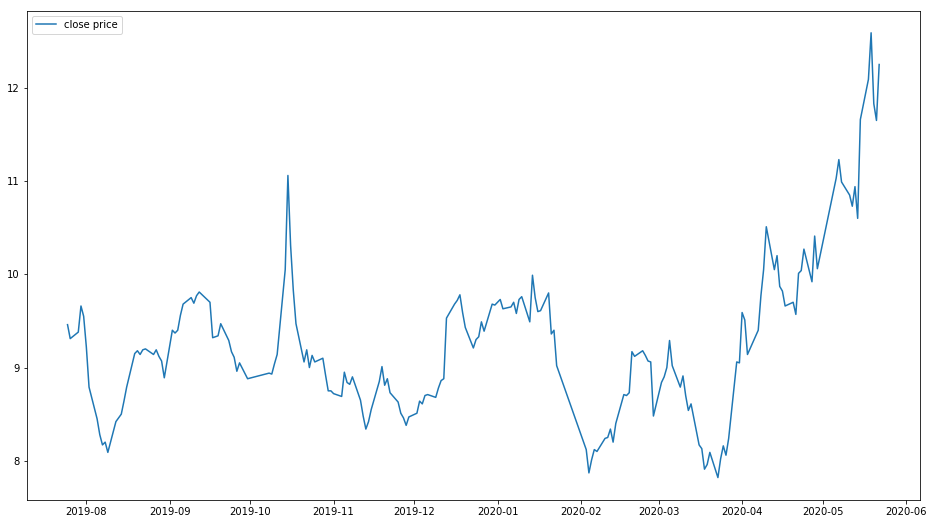

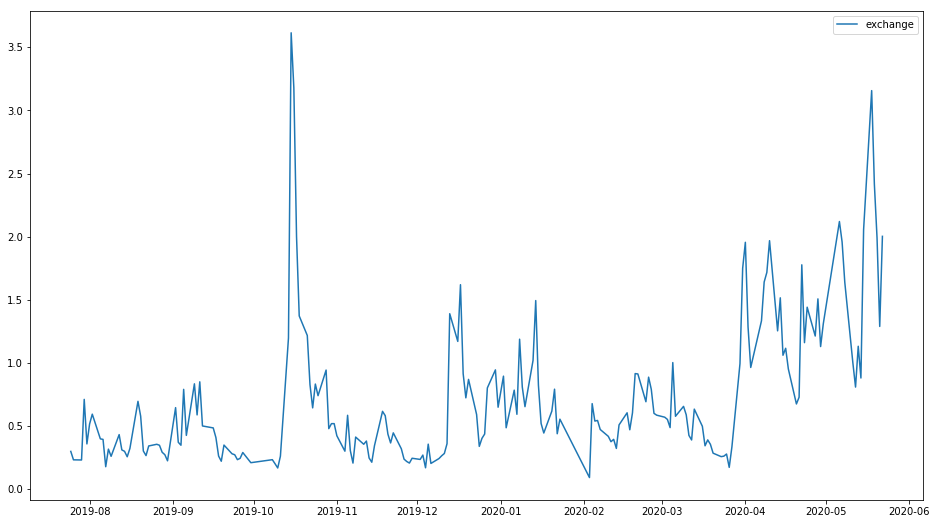

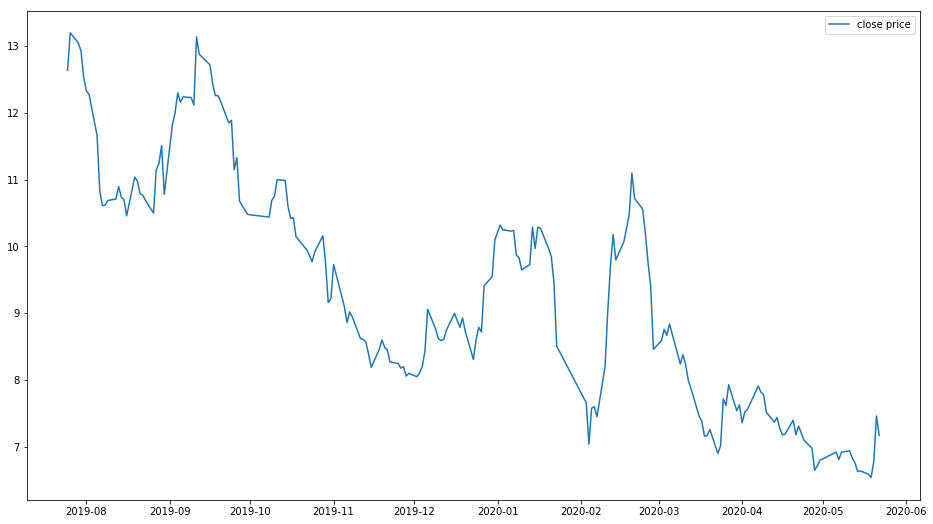

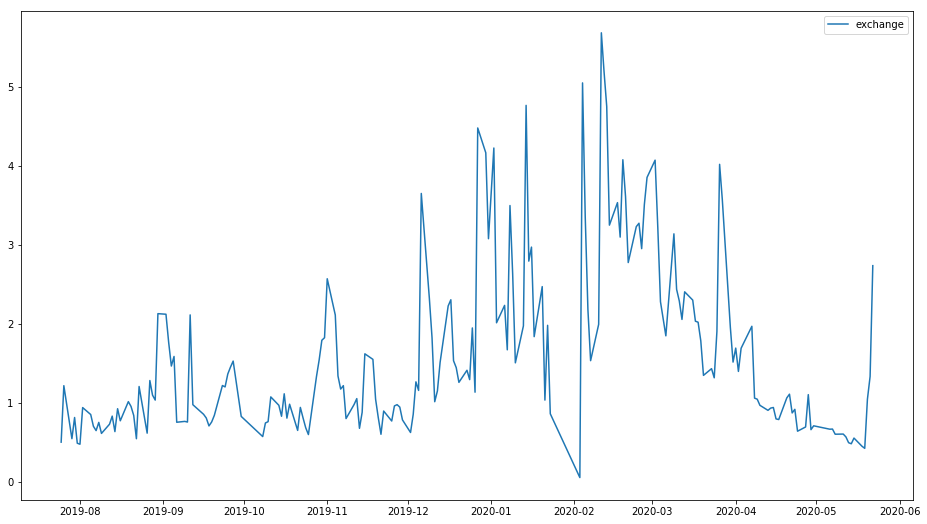

In [8]:
d1 = ana(path="/Users/luokui/Downloads/000987.csv")
d2 = ana(path="/Users/luokui/Downloads/603959.csv")

# 分析两个股票之间的 相关性

In [423]:
def stock_cor(d1, data, h = 50, key='收盘价', method="kendall"):
    #c1 = np.corrcoef(d1['开盘价'].head(h), data['开盘价'].head(h), "kendal")
    #c2 = np.corrcoef(d1['开盘价'].head(h), data['开盘价'].head(h), "pearson")
    test = pd.merge(d1[['日期', key]].head(h), data[['日期', key]].head(h), on='日期', how='left')
    print(test.corr(method=method))
    
stock_cor(d1, d2)

          收盘价_x     收盘价_y
收盘价_x  1.000000 -0.404421
收盘价_y -0.404421  1.000000


In [435]:
# plt.figure(figsize=(16, 9))
# plt.plot(pd.to_datetime(d1['日期'].head(h)), d1['开盘价'].head(h))
# plt.plot(pd.to_datetime(data['日期'].head(h)), data['开盘价'].head(h))

In [436]:
# test = pd.merge(d1[['日期', '收盘价']].head(h), data[['日期', '收盘价']].head(h), on='日期', how='left')
# #test.corr(method="kendall")
# test.corr()

In [252]:
d1['换手率'].describe(percentiles=[.25, .50, .8, 0.9])

count    200.000000
mean       1.598856
std        1.092090
min        0.054200
25%        0.811650
50%        1.205000
80%        2.283240
90%        3.254010
max        5.688000
Name: 换手率, dtype: float64

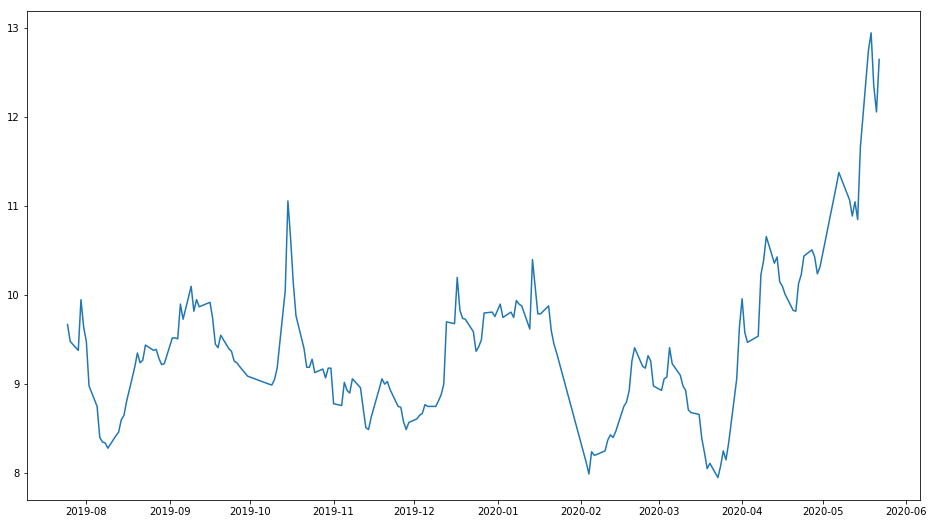

In [437]:
def plots(data, key='最高价'):
    plt.figure(figsize=(16, 9))
    #data['涨跌额']
    plt.plot(pd.to_datetime(data['日期']), data[key].astype("float"))
plots(d1)

In [136]:
data[['收盘价', '换手率']].corr()

,收盘价,换手率
收盘价,1.000000,-0.021568
换手率,-0.021568,1.000000


In [140]:
data['mean'] = pd.rolling_mean(data['最高价'], window=10)
data.fillna(method='ffill')
data.head(10)

/Users/luokui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  """Entry point for launching an IPython kernel.


,日期,股票代码,名称,收盘价,最高价,最低价,开盘价,前收盘,涨跌额,涨跌幅,换手率,成交量,成交金额,总市值,流通市值,mean
0,2020-05-22,'603959,百利科技,7.17,7.58,6.96,7.58,7.46,-0.29,-3.8874,2.7383,12022328,86511198.0,3.147917e+09,3.147917e+09,NaN
1,2020-05-21,'603959,百利科技,7.46,7.46,6.78,6.82,6.78,0.68,10.0295,1.3350,5861139,43128438.0,3.275238e+09,3.275238e+09,NaN
2,2020-05-20,'603959,百利科技,6.78,6.81,6.47,6.53,6.54,0.24,3.6697,1.0463,4593596,30861825.0,2.976691e+09,2.976691e+09,NaN
3,2020-05-19,'603959,百利科技,6.54,6.68,6.53,6.65,6.59,-0.05,-0.7587,0.4245,1863913,12265291.0,2.871322e+09,2.871322e+09,NaN
4,2020-05-18,'603959,百利科技,6.59,6.76,6.57,6.76,6.64,-0.05,-0.753,0.4503,1976897,13094192.0,2.893274e+09,2.893274e+09,NaN
5,2020-05-15,'603959,百利科技,6.64,6.68,6.54,6.67,6.63,0.01,0.1508,0.5544,2434085,16067624.0,2.915226e+09,2.915226e+09,NaN
6,2020-05-14,'603959,百利科技,6.63,6.75,6.63,6.75,6.76,-0.13,-1.9231,0.4824,2117757,14124900.0,2.910835e+09,2.910835e+09,NaN
7,2020-05-13,'603959,百利科技,6.76,6.85,6.70,6.85,6.83,-0.07,-1.0249,0.4958,2176927,14682317.0,2.967910e+09,2.967910e+09,NaN
8,2020-05-12,'603959,百利科技,6.83,6.95,6.80,6.95,6.94,-0.11,-1.585,0.5692,2498829,17112541.0,2.998643e+09,2.998643e+09,NaN
9,2020-05-11,'603959,百利科技,6.94,7.07,6.88,6.93,6.92,0.02,0.289,0.6052,2656958,18499165.0,3.046938e+09,3.046938e+09,6.959


# 分析换手率

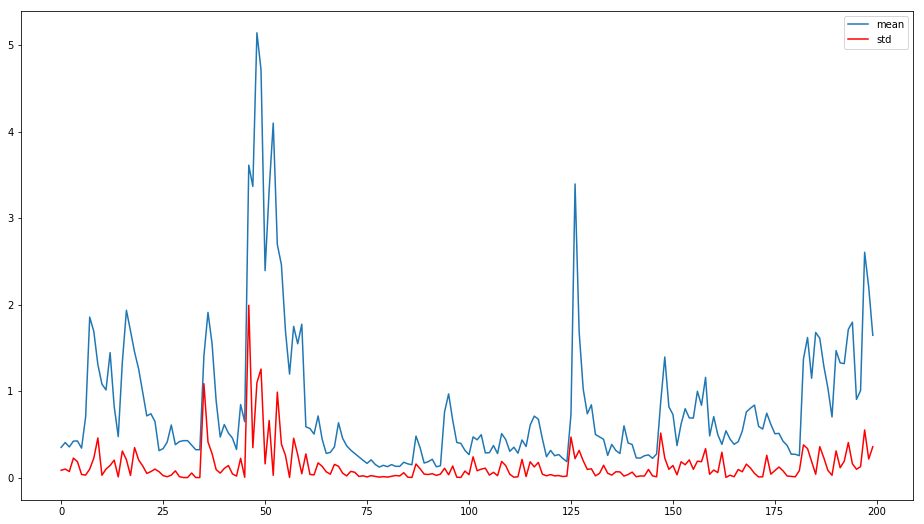

In [221]:
import numpy as np

te = data['换手率']

def plot_data(da, k=5):
    new = []
    new_std = []
    for i in range(len(da) // k):
        temp = da[k * i :(i + 1) * k]
        new.append(np.mean(temp))
        new_std.append(np.std(temp))
    plt.figure(figsize=(16, 9))
    plt.plot(np.arange(len(new)), new[::-1])
    plt.plot(np.arange(len(new)), new_std[::-1], color='red')
    plt.legend(['mean', 'std'])
plot_data(te, k=2)

In [ ]:
# 换手率 较高但不太高
# 股价逐步升高，但是不太高。
# 股价处于最近一段时间的  地位，或者 最近一段时间的 变化不大。


# 换手率与股价的关系

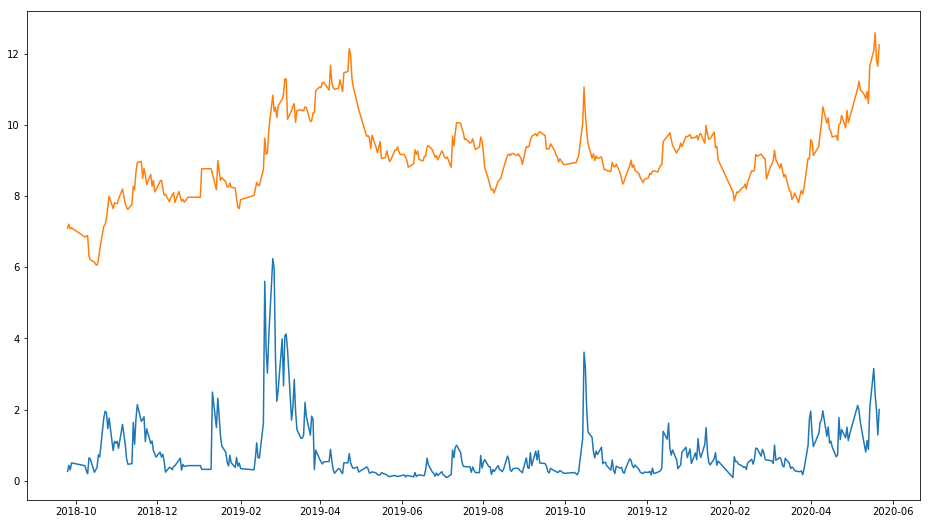

In [223]:
plt.figure(figsize=(16, 9))
#data['涨跌额']
plt.plot(pd.to_datetime(data['日期']), data['换手率'].astype("float"))
plt.plot(pd.to_datetime(data['日期']), data['收盘价'].astype("float"))

# 突破策略

In [217]:
# data['收盘价'].diff(1)
def up(data):
    data['high_n'] = pd.rolling_max(data['最高价'], window=4)
    expand_max = pd.expanding_max(data['收盘价'])
    data['high_n'].fillna(value = expand_max, inplace=True)

    data['low_n'] = pd.rolling_min(data['最低价'], window=5)
    expand_min = pd.expanding_min(data['收盘价'])
    data['low_n'].fillna(value = expand_min, inplace=True)

    plt.figure(figsize=(16, 9))
    #data['涨跌额']
    plt.plot(pd.to_datetime(data['日期']), data['high_n'].astype("float"))

    buy_index = data[data['收盘价'] > data['high_n'].shift(1)].index
    data.loc[buy_index, "signal"] = 1

    sell_index = data[data['收盘价'] < data['low_n'].shift(1)].index
    data.loc[sell_index, "signal"] = -1

    data = data.fillna(0)

    print(data.signal.value_counts())#.plot(kind="pie", figsize=(5, 5))

    data['keep'] = data['signal'].shift(1)
    data['keep'].fillna(method='ffill', inplace=True)

/Users/luokui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_max is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).max()
  
/Users/luokui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.expanding_max is deprecated for Series and will be removed in a future version, replace with 
	Series.expanding(min_periods=1).max()
  This is separate from the ipykernel package so we can avoid doing imports until


# 其他数据测试

In [284]:

import multiprocessing

import requests
from bs4 import BeautifulSoup
import re
import bs4
import time

import numpy as np


class Job:
    def __init__(self,
                 n_page=12,
                 n_jobs=4,
                 name_path="name.txt",
                 hot_path="hot.txt"):
        self.n_page = n_page
        self.n_jobs = n_jobs
        self.name_path = name_path
        self.hot_path = hot_path

    def split_data(self, n_jobs):
        page_list = np.arange(1, self.n_page + 1)
        indexs = int((self.n_page - 1) / n_jobs) + 1
        for id in range(n_jobs):
            yield page_list[indexs * id: (id + 1) * indexs]

    def savedata_multiprocess(self):
        # logging.log(logging.INFO, "db infomation are {}".format(mins))
        if self.n_jobs == -1:
            # 获取 cpu的个数
            n_jobs = multiprocessing.cpu_count() - 2
        else:
            n_jobs = self.n_jobs

        q = multiprocessing.Queue()
        myqueus = []
        sums = 0
        for ids, p_list in enumerate(self.split_data(n_jobs)):
            temp_job = multiprocessing.Process(target=self.get_latest, args=(q, p_list), name="jon_{}".format(ids))
            myqueus.append(temp_job)
        for job in myqueus:
            job.start()
        for job in myqueus:
            job.join()
        for _ in range(n_jobs):
            #print(q.get())
            sums += q.get()
        print("total stocks is {}".format(sums))
        #logging.log(logging.INFO, "Data are saved, total table is {}, save table is {}".format(allcount, sums))

    #@classmethod
    def get_latest(self, q, page_list):
        # 获取若干页的数据
        myhot = {}
        mymaps = {}
        for i in page_list:
            d = requests.get("http://guba.eastmoney.com/default,0_{}.html".format(i))
            soup = BeautifulSoup(d.text, 'lxml')
            res = soup.find_all(class_="balink")
            maps, hot = self.get_gubai(res)
            mymaps.update(maps)
            for key in hot.keys():
                if key in myhot.keys():
                    myhot[key] += hot[key]
                else:
                    myhot.setdefault(key, hot[key])
        counts = len(myhot.keys())
        if self.name_path:
            self.save_data(self.name_path, mymaps)
        if self.hot_path:
            self.save_data(self.hot_path, myhot)
        q.put(counts)

    def save_data(self, path, dict_data):
        with open(path, "a") as f:
            for key, value in dict_data.items():
                line = " ".join([key, str(value)])
                f.write(line + '\n')

    def get_gubai(self, res, save=('0', '6')):
        # '603321': ['梅轮电梯吧', '/list,603321.html']
        maps = {}
        hot = {}
        for line in res:
            temp_line = line['href']
            ids = temp_line.split(',')[1].split('.')[0]
            if ids[0] not in save:
                    continue
            name = line.string
            maps.setdefault(ids, [name, temp_line])
            hot.setdefault(ids, 0)
            hot[ids] += 1
        return maps, hot


if __name__ == "__main__":
    myobj = Job(n_page=30, n_jobs=2)
    myobj.savedata_multiprocess()

total stocks is 990
